<a href="https://colab.research.google.com/github/Ariara61/ESAA/blob/main/%ED%95%B8%EC%A6%88%EC%98%A8_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_245_271.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter7 앙상블 학습과 랜덤 포레스트

* 대중의 지혜: 무작위로 선택된 수천 명의 사람들의 답이 전문가의 답보다 나은 것
* 일련의 예측기(앙상블)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음
* 앙상블 학습
* 앙상블 방법: 앙상블 학습 알고리즘

* 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킬 수 있음. 예측을 하려면 모든 개별 트리의 예측을 구하면 됨.
* 그리고 가장 많은 선택을 받은 클래스를 예측으로 삼음
* 랜덤 포레스트: 결정 트리의 앙상블

## 7.1 투표 기반 분류기
* 여러 분류기 훈련시키기
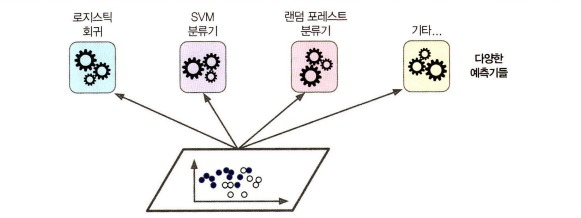


* 직접 투표 분류기: 각 분류기의 에측을 모아서 가장 많이 선택된 클래스를 예측

* 직접 투표 분류기의 에측
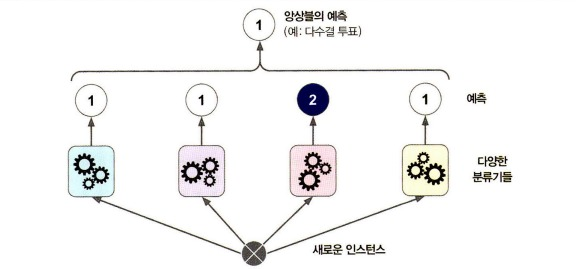

* 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많음.
* 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있음.

* 큰 수의 법칙: 큰 표본 크기에서의 평균 결과가 전체 모집단의 평균에 점점 가까워진다는 통계적 원칙

* 큰 수의 법칙
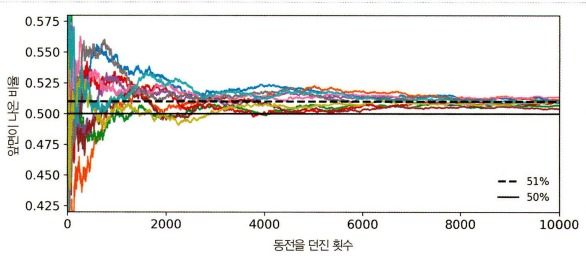

* 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다고 가정.
* 가장 많은 클래스를 예측으로 삼는다면 75%의 정확도를 기대할 수 있음.
* 하지만 이런 가정은 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 가능함.
* 하지만 여기서는 같은 데이터로 훈련시키기 때문에 이런 가정이 맞지 않음.
* 분류기들이 같은 종류의 오차를 만들기 쉽기 때문에 잘못된 클래스가 다수인 경우가 많고 앙상블의 정확도가 낮아짐.

In [1]:
#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [("lr", log_clf), ("rf", rnd_clf), ("svc", svm_clf)],
    voting = "hard"
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test,y_pred))

LogisticRegression 0.9
RandomForestClassifier 1.0
SVC 0.95
VotingClassifier 0.95


* 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높음.

* 간접 투표: 모든 분류기가 클래스의 확률을 예측할 수 있으면 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 것
* 이 방식은 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음.
* voting = "hard"를 voting = "soft"로 바꾸고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨.
* SVC 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함.

## 7.2 배깅과 페이스팅
* 같은 알고리즘을 사용하고 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시킴.
* 배깅: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
* 페이스팅: 중복을 허용하지 않고 샘플링하는 방식

* 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 에측기에 걸쳐 사용할 수 있음.
* 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있음.

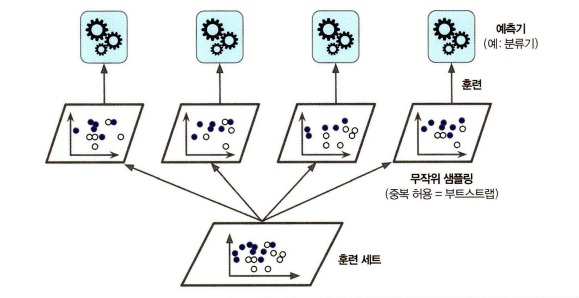

* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦.
* 수집 함수는 전형적으로 분류일 때는 통계적 최빈값이고 회귀에 대해서는 평균을 계산.
* 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소함.
* 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦.

### 7.2.1 사이킷런의 배깅과 페이스팅
* 사이킷런은 배깅과 페이스팅을 위해 BaggingClassifier(회귀의 경우 BaggingRegressor)를 제공.

In [4]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    max_samples = 50, bootstrap = True, n_jobs = -1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

* 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교
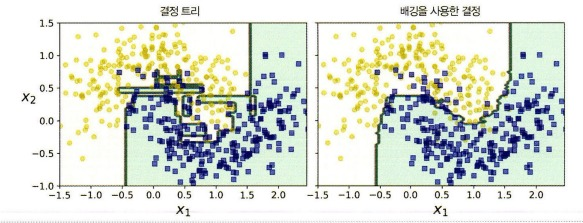

* 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 됨.
* 앙상블은 비슷한 편향에서 더 작은 분산을 만듦.
* 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음.
* 하지만 다양성을 추가한다는 것은 예측기들이 상관관계를 줄이므로 앙상블의 분산을 감소시킴.
* 전반적으로 배깅이 더 나은 모델을 만들기 때문에 일반적으로 더 선호함.

### 7.2.2 oob 평가
* 배깅을 사용하면 어떤 샘플은 한 에측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수 있음.
* BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개 샘플을 선택함.
* 이는 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미. 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 부름.
* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있음.
* 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음.
* 사이킷런에서 BoostingClassifier를 만들 때 oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행함.
* 평가 점수 결과는 oob_score_변수에 저장

In [5]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.925

In [6]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

* oob 샘플에 대한 결정 함수의 값도 oob_decision_function_ 변수에서 확인할 수 있음.
* 결정 함수는 각 훈련 샘플의 클래스 확률을 반환

In [7]:
bag_clf.oob_decision_function_

array([[0.03389831, 0.96610169],
       [0.95833333, 0.04166667],
       [0.        , 1.        ],
       [0.3       , 0.7       ],
       [0.03626943, 0.96373057],
       [0.02116402, 0.97883598],
       [0.02645503, 0.97354497],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.01129944, 0.98870056],
       [0.99453552, 0.00546448],
       [0.69767442, 0.30232558],
       [0.        , 1.        ],
       [0.98369565, 0.01630435],
       [0.        , 1.        ],
       [0.97948718, 0.02051282],
       [0.        , 1.        ],
       [0.96954315, 0.03045685],
       [0.99459459, 0.00540541],
       [0.98224852, 0.01775148],
       [0.38020833, 0.61979167],
       [0.48066298, 0.51933702],
       [0.74358974, 0.25641026],
       [0.85106383, 0.14893617],
       [0.        , 1.        ],
       [0.00552486, 0.99447514],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.14184397, 0.85815603],
       [0.8994709 , 0.1005291 ],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스
* BaggingClassifier은 특성 샘플링도 지원
* 샘플링은 max_features, bootstrap_features 두 매개변수로 조절
* 작동 방식은 max_samples, bootstrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링임
* 따라서 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨.
* (이미지와 같은) 매우 고차원의 데이터셋을 다룰 때 유용.
* 랜덤 패치 방식: 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스 방식: 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

# 7.4 랜덤 포레스트
* 랜덤 포레스트: 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블
* 전형적으로 max_samples를 훈련 세트의 크기로 지정.
* BaggingClassifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있음.

In [8]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

* RandomforestClassifier는 DecisionTreeClassifier의 매개변수와 앙상블 자체를 제어하는 데 필요한 BaggingClassifier의 매개변수를 모두 가지고 있음.
* 랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함.
* 이는 결국 트리를 결국 다양하게 만들고 편향을 손해보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 만들어냄.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features = "auto", max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, n_jobs = -1)

### 7.4.1 엑스트라 트리
* 트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함.
* 익스트림 랜덤 트리 앙상블(엑스트라 트리): 극단적으로 무작위한 트리의 랜덤 포레스트
* 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요도는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠름.
* 사이킷런의 ExtraTreesClassifier을 사용. 사용법은 RandomForestClassifier와 같음.
* ExtraTreesRegressor도 RandomForestRegressor와 같은 API를 제공.


### 7.4.2 특성 중요도
* 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함. 더 정확히 말하면 가중치 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.
* 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 이 점수를 계산하고 중요도의 전체 합이 1이 되도록 결괏값을 정규화함. 이 값은 feature_importances_ 변수에 저장되어 있음.

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10542098612275382
sepal width (cm) 0.02221029207764233
petal length (cm) 0.43439399169874976
petal width (cm) 0.43797473010085414


* 가장 중요한 특성은 꽃잎의 길이(44%)와 너비(42%)이고 꽃받침의 길이와 너비는 비교적 덜 중요해보임.

* (랜덤 포레스트 분류기에서 얻은) MNIST 픽셀 중요도
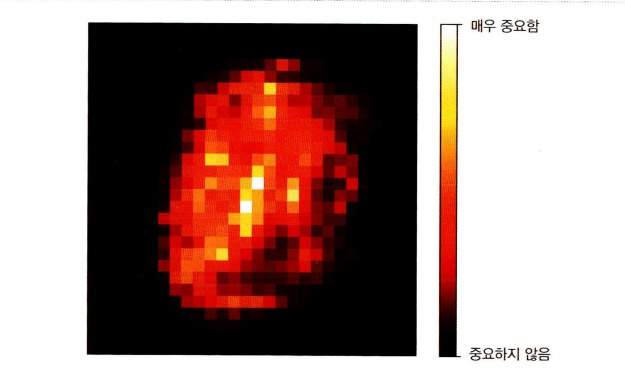

## 7.5 부스팅
* 부스팅: 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법.
* 가장 인기 있는것은 에이다부스트와 그레이디언트부스팅.

### 7.5.1 에이다부스트
* 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높임. 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.
* 에이다부스트 분류기를 만들 때 먼저 알고리즘이 기반이 되는 첫 분류기를 훈련 세트에서 훈련시키고 예측을 만듦. 그 다음에 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임. 두 번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦. 그 다음에 다시 가중치를 업데이트하는 식으로 계속함.

* 샘플의 가중치를 업데이트하면서 순차적으로 학습하는 에이다부스트
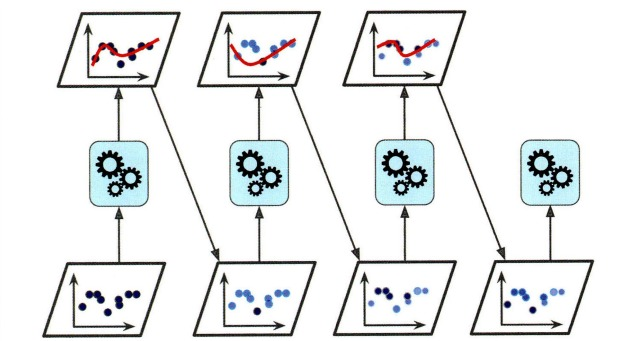


* 연속된 예측기의 결정 경계
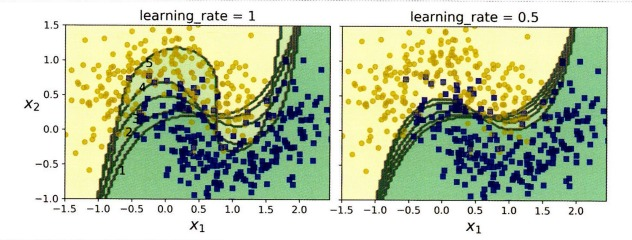

* 첫 번째 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아짐. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 됨.
* 이러한 연속된 학습 기법은 경사 하강법과 비슷한 면이 있음.
* 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함.
* 모든 예측기가 훈련을 마치면 이 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦.
* 하지만 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨.
* 각 샘플 가중치 $w^{(i)}$는 초기에 $\frac{1}{m} $로 초기화됨. 첫 번째 예측기가 학습되고, 가중치가 적용된 에러율 $r_{1}$이 훈련 세트에 대해 계산됨.

* j번째 예측기의 가중치가 적용된 에러율
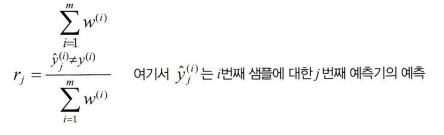

* 예측기 가중치: $\alpha _{j} =  \eta log \frac{1-r_{j}}{r_{j}} $
 * $\eta$: 학습률 하이퍼파라미터
 * 예측기가 정확할수록 가중치가 더 높아지게 됨.
 * 무작위로 예측하는 정도라면 가중치가 0에 가깝고, 그보다 나쁘면 가중치는 음수가 됨.

* 가중치 업데이트 규칙
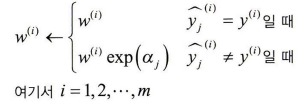


* 가중치를 업데이트한 후, 모든 샘플의 가중치를 정규화함.
* 새 예측기가 업데이트도니 가중치를 사용해 훈련되고 전체 과정이 반복됨.
* 이 알고리즘은 지정된 예측기 수에 도달하거나 완벽한 예측기가 만들어지면 중지됨.

* 에이다부스트 예측:
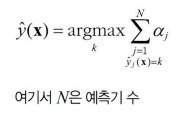

* 사이킷런은 SAMME라는 에이다부스트의 다중 클래스 버전을 사용.
* 클래스가 두 개뿐일 때는 SAMME가 에이다부스트와 동일함.
* 예측기가 클래스의 확률을 추정할 수 있다면 사이킷런은 SAMME.R이라는 SAMME의 변종을 사용함. 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋음.


In [11]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth = 1), n_estimators = 200,
    algorithm = "SAMME.R", learning_rate = 0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그래디언트 부스팅
* 그래디언트 부스팅: 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함.
* 하지만 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴.


In [12]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 =  DecisionTreeRegressor(max_depth = 2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [13]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth = 2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [14]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth = 2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [16]:
# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

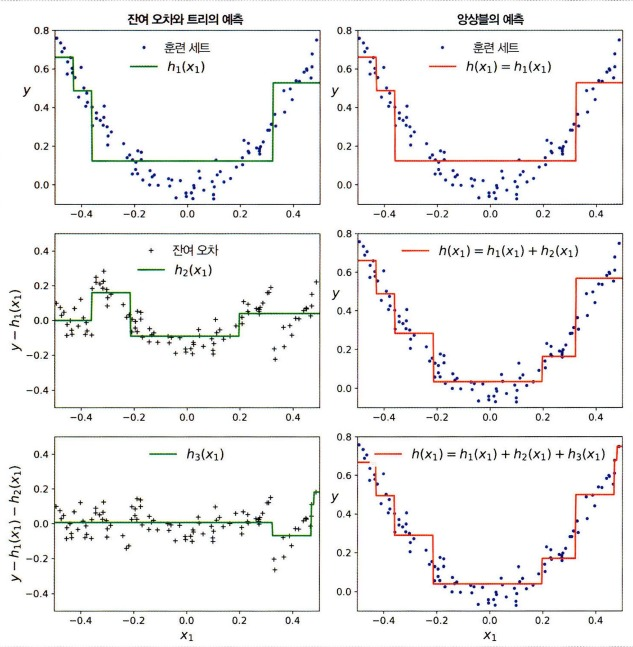

* 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리와 완전히 같음.
* 두 번째 행에서는 새로운 트리의 잔여 오차에 대해 학습됨. 오른쪽 앙상블 예측이 두 개의 트리 예측의 합과 같음.
* 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련됨. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있음.
* 사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있음.
 * 매개변수: n_estimators, max_depth, min_samples_leaf

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 3, learning_rate = 1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

* learning_rate: 각 트리의 기여 정도를 조절
 * 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측 성능은 좋아짐. (축소)

 * 예측기가 부족한 경우(왼쪽)와 너무 많은 경우(오른쪽)의 GBRT 앙상블
 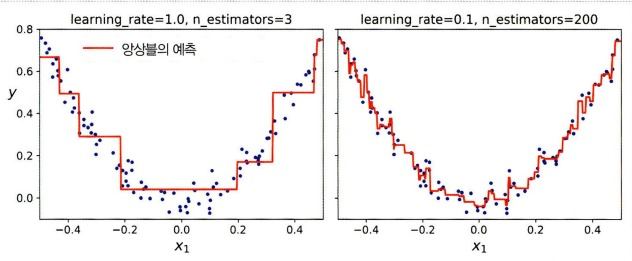


* 최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있음. - staged_predict 메서드 사용.

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth = 2, n_estimators = 120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth = 2, n_estimators = bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=14)

* 조기 종료를 사용하여 트리 수 튜닝
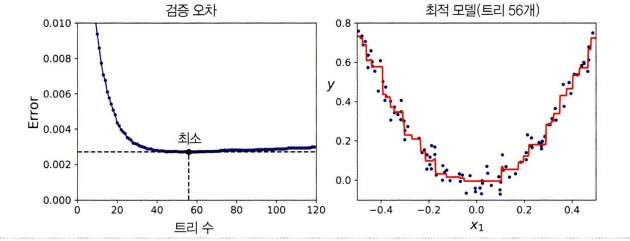

* 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수 있음.
* warm_start = True로 설정하면 사이킷런이 fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌.

In [19]:
gbrt = GradientBoostingRegressor(max_depth = 2, warm_start = True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_goint_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break   # 조기 종료

* GradientBoostingRegresso는 각 트리가 훈련될 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개변수도 지원함.
* 편향이 높아지는 대신 분산이 낮아지게 됨. 또, 훈련 속도를 상당히 높임.
* 확률적 그레이디언트 부스팅: 그레이디언트 부스팅 알고리즘에서 각 단계에서 훈련 데이터의 일부분(무작위로 샘플링된)만을 사용하여 트리를 학습시키는 방법
* XGBoost: 익스트림 그레이디언트 부스팅
 * 목표: 매우 빠른 속도, 확장성, 이식성

In [25]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [27]:
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds = 2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41830
[1]	validation_0-rmse:0.38051
[2]	validation_0-rmse:0.37349
[3]	validation_0-rmse:0.37701
[4]	validation_0-rmse:0.38023


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


## 7.6 스태킹
* 스태킹: 여러 개의 다른 모델들의 예측 결과를 입력으로 사용하여 새로운 메타 모델을 훈련시켜 최종 예측을 생성하는 앙상블 학습 방법
* 블렌더(메터 학습기): 스태킹(스태킹 앙상블)에서 여러 기본 모델들의 예측을 결합하여 최종 예측을 생성하는 모델
* 블렌딩 예측기를 사용한 예측 취합
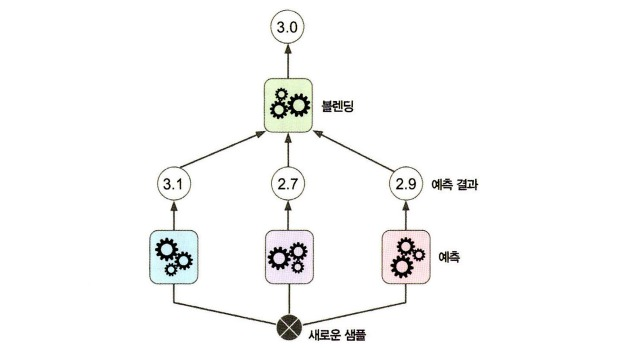


* 블렌더를 학습시키는 일반적인 방법: 홀드 아우세 세트를 사용

* 첫 번째 레이어 훈련하기
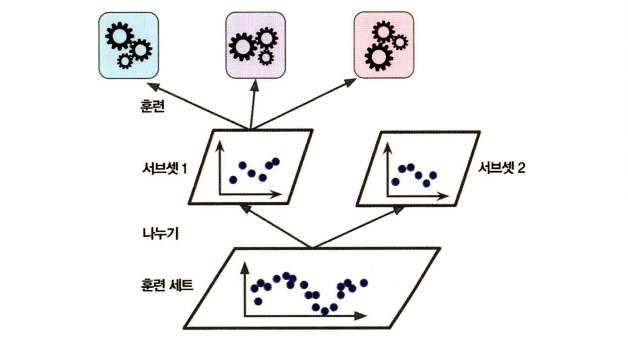

* 훈련 세트를 두 개의 서브셋으로 나눈 후, 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용됨.
* 첫 번째 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만듦. 예측기들이 훈련하는 동안 이 샘플들을 전혀 보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것임.
* 홀드 아웃 세트의 각 샘플에 대해 세 개의 예측값이 있음. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있음.
* 즉, 첫 번째 레이어의 예측을 가지고 타깃값을 예측하도록 학습됨.

* 블렌더 훈련
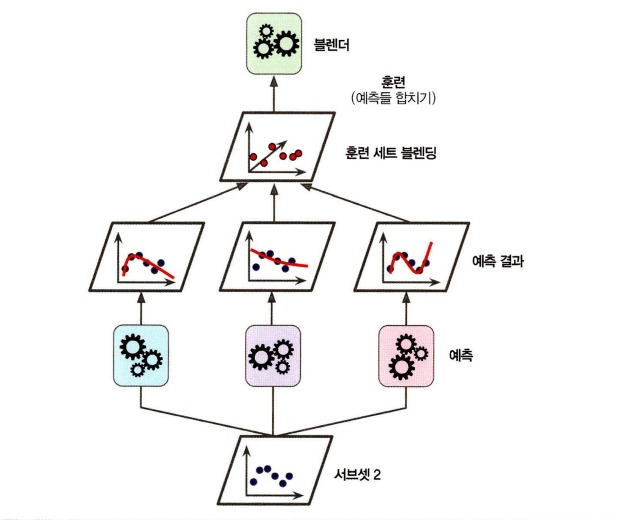

* 블렌더를 여러 개 훈련시키는 것도 가능함.
* 그러면 블렌더만의 레이어가 만들어지게 되는데, 이렇게 하려면 훈련 세트를 세 개의 서브셋으로 나눠야 함.
* 첫 번째 세트는 첫 번째 레이어를 훈련시키는 데 사용되고 두 번째 세트는 두 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨. 그리고 세 번째 세트는 세 번째 레이어를 훈련시키기 위한 훈련 세트를 만드는 데 사용됨.
* 각 레이어를 차례대로 실행해서 새로운 샘플에 대한 예측을 만들 수 있음.

* 멀티 레이어 스태킹 앙상블의 예측
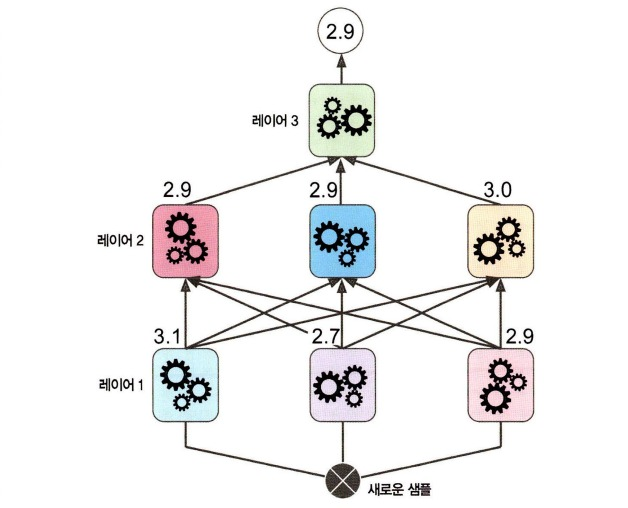


* 사이킷런은 스태킹을 직접 지원하지 않음.
* DESlib 같은 오픈 소스 구현을 사용할 수 있음.